In [8]:
# Config Data Structure
import IPython
import IPython.display

import pandas as pd
import numpy as np
import pprint as pp
import random as ran
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from functools import reduce
from collections import Counter
from datetime import datetime as dt
from pymongo import MongoClient as mc

sns.set(rc={'figure.figsize': (15.7, 13.27)})
plt.rcParams['figure.figsize'] = 15.7,13.27
plt.rcParams['font.family'] = 'AppleGothic'

mongo_uri = "mongodb://localhost:27017"
client = mc(mongo_uri)
keti_db = client.keti_pattern_recognition

household_col = keti_db.household_info
cluster_col = keti_db.cluster_info
weather_col = keti_db.weather_info

uid = "아파트4-103-106"

# TimeSlot In
hh_db_datas = household_col.find_one({"uid": uid})
hh_db_datas

hh_datas = pd.DataFrame(columns=['Date Time', 'kw (15min)', 'ta (avg)', 'rhm (avg)'])
timeslot = hh_db_datas['timeslot']

wt_db_datas = weather_col.find()
wt_datas = pd.DataFrame()

for wt in wt_db_datas:
    tmp = pd.DataFrame()
    tmp['date'] = [wt['date']]
    tmp['avg_ta'] = float(wt['avgTa'])
    tmp['avg_rhm'] = float(wt['avgRhm'])
    
    wt_datas = pd.concat([wt_datas, tmp])
    
avg_ta = reduce(lambda acc,cur: acc + [cur for i in range(0,96)], wt_datas['avg_ta'], [])
avg_rhm = reduce(lambda acc,cur: acc + [cur for i in range(0,96)], wt_datas['avg_rhm'], [])

hh_datas['Date Time'] = [ts['time'] for ts in timeslot]
hh_datas['kw (15min)'] = [ts['power'] for ts in timeslot]
hh_datas['ta (avg)'] = avg_ta
hh_datas['rhm (avg)'] = avg_rhm

hh_datas = hh_datas[0::4]
date_time = pd.to_datetime(hh_datas.pop('Date Time'), format="%Y-%m-%d T%H:%M Z")

hh_datas

# plot_cols=['kw (15min)', 'ta (avg)', 'rhm (avg)']
# plot_features = hh_datas[plot_cols]
# plot_features.index = date_time
# _ = plot_features.plot(subplots=True)

# plot_features = hh_datas[plot_cols][:168]
# plot_features = hh_datas[:168]
# _ = plot_features.plot(subplots=True)
df = hh_datas.copy()
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]
df.shape # 9개의 특성을 가진 데이터가 8760 개

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')

class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

def plot(self, model=None, plot_col='kw (15min)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

val_performance = {}
performance = {}

# Single Step Model
---
### 현재 조건에만 기초하여 미래로 1시간 진행된 단일 특성 값을 예측하는 모델
- Baseline Model
- Linear Model
- Dense Model

In [26]:
single_step_window = WindowGenerator(
    input_width=2, label_width=2, shift=1,
    label_columns=['kw (15min)'])
single_step_window

Total window size: 3
Input indices: [0 1]
Label indices: [1 2]
Label column name(s): ['kw (15min)']

In [27]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['kw (15min)'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['kw (15min)']

## Baseline Model 
---
### 후에 복잡한 모델과의 비교를 위해서 설계하는 모델로, 기본적으로 이전 시간대의 값을 그대로 출력하는 특성을 가진다.

55/55 [==============================] - 0s 1ms/step - loss: 0.7029 - mean_absolute_error: 0.3858


/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


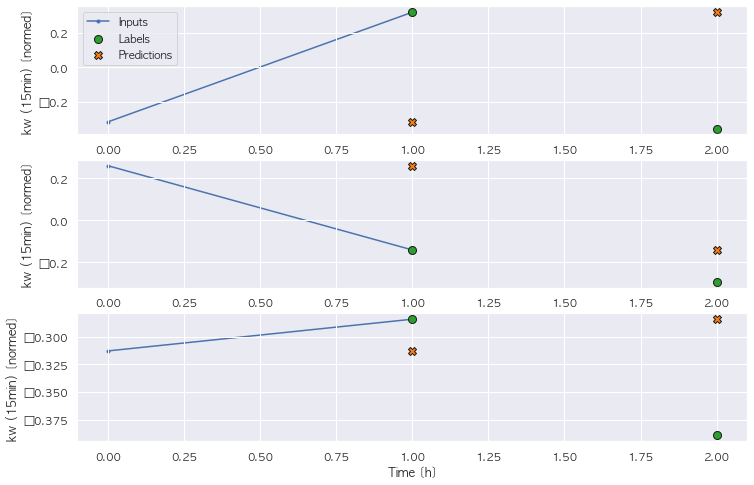

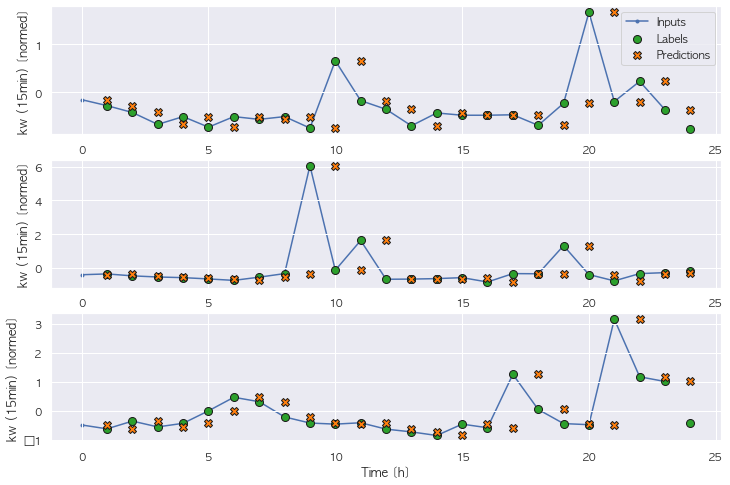

In [58]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

baseline = Baseline(label_index=column_indices['kw (15min)'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

single_step_window.plot(baseline)
wide_window.plot(baseline)

## Linear Model
---
### 입력층과 출력층 사이에 선형층을 하나 추가한다는 특징을 가진다.
- 이 때의 해당 타임스텝의 출력은 해당 스텝에만 의존한다.

Epoch 1/20
192/192 [==============================] - 1s 2ms/step - loss: 1.8818 - mean_absolute_error: 1.0175 - val_loss: 1.5847 - val_mean_absolute_error: 0.9603
Epoch 2/20
192/192 [==============================] - 0s 1ms/step - loss: 1.5020 - mean_absolute_error: 0.8789 - val_loss: 1.2525 - val_mean_absolute_error: 0.8460
Epoch 3/20
192/192 [==============================] - 0s 2ms/step - loss: 1.2569 - mean_absolute_error: 0.7722 - val_loss: 1.0260 - val_mean_absolute_error: 0.7569
Epoch 4/20
192/192 [==============================] - 0s 2ms/step - loss: 1.1067 - mean_absolute_error: 0.6959 - val_loss: 0.8798 - val_mean_absolute_error: 0.6964
Epoch 5/20
192/192 [==============================] - 0s 1ms/step - loss: 1.0186 - mean_absolute_error: 0.6433 - val_loss: 0.7926 - val_mean_absolute_error: 0.6647
Epoch 6/20
192/192 [==============================] - 0s 1ms/step - loss: 0.9688 - mean_absolute_error: 0.6100 - val_loss: 0.7431 - val_mean_absolute_error: 0.6505
Epoch 7/20
192/1

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


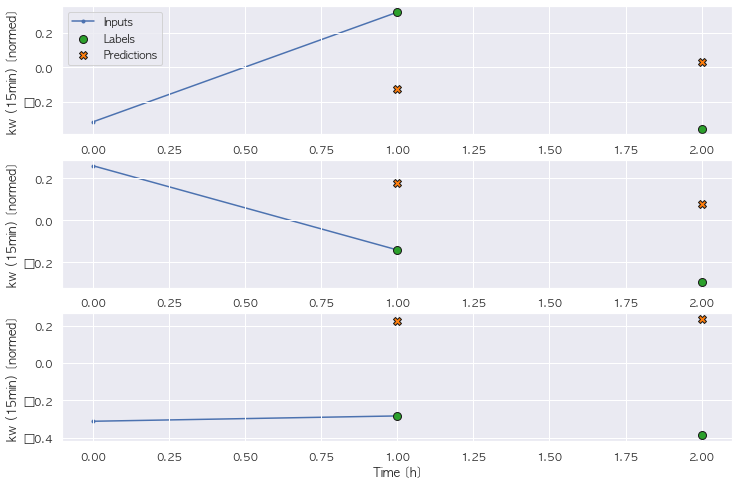

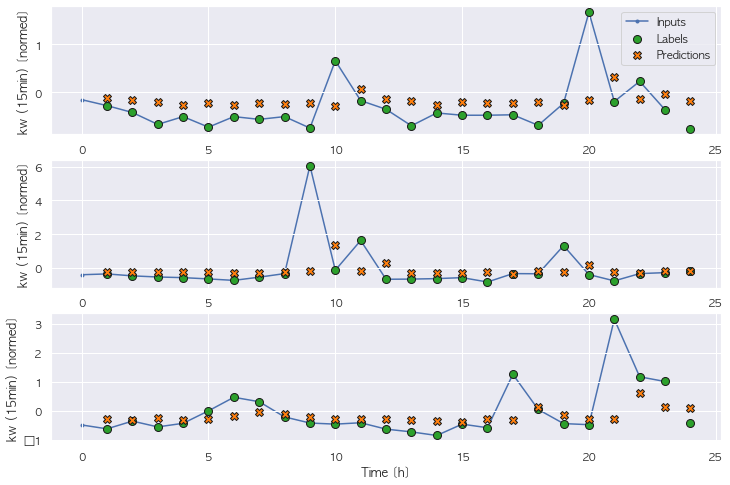

In [59]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

single_step_window.plot(linear)
wide_window.plot(linear)

## Dense Model
---
### 밀집층을 여러개 추가한 케이스 (활성화 함수 포함)
- linear model과 거의 유사하지만, 활성화 함수를 포함한 은닉층을 추가한다는 점이 다르다.
- 실제로 복잡한 모델에 들어가기전에, 해당 모델의 성능을 확인하는 것이 좋다.

Epoch 1/20
192/192 [==============================] - 1s 2ms/step - loss: 0.9282 - mean_absolute_error: 0.5810 - val_loss: 0.7663 - val_mean_absolute_error: 0.7045
Epoch 2/20
192/192 [==============================] - 0s 2ms/step - loss: 0.9108 - mean_absolute_error: 0.5720 - val_loss: 0.7548 - val_mean_absolute_error: 0.7016
Epoch 3/20
192/192 [==============================] - 0s 2ms/step - loss: 0.9079 - mean_absolute_error: 0.5704 - val_loss: 0.7676 - val_mean_absolute_error: 0.7148
Epoch 4/20
28/28 [==============================] - 0s 1ms/step - loss: 0.5395 - mean_absolute_error: 0.6182


/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


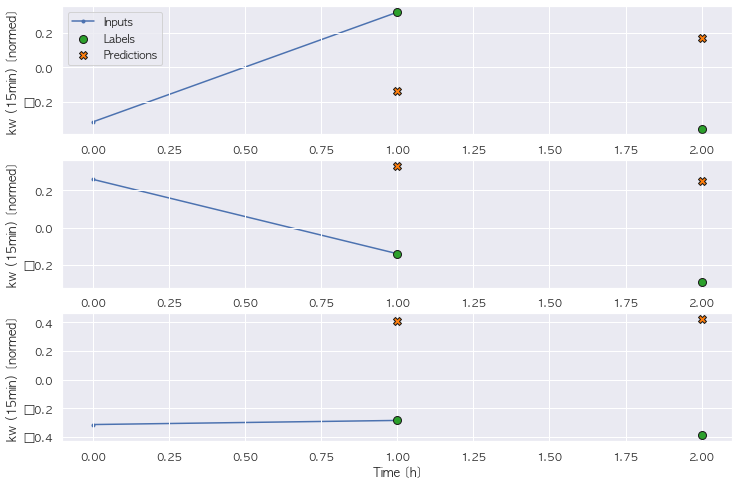

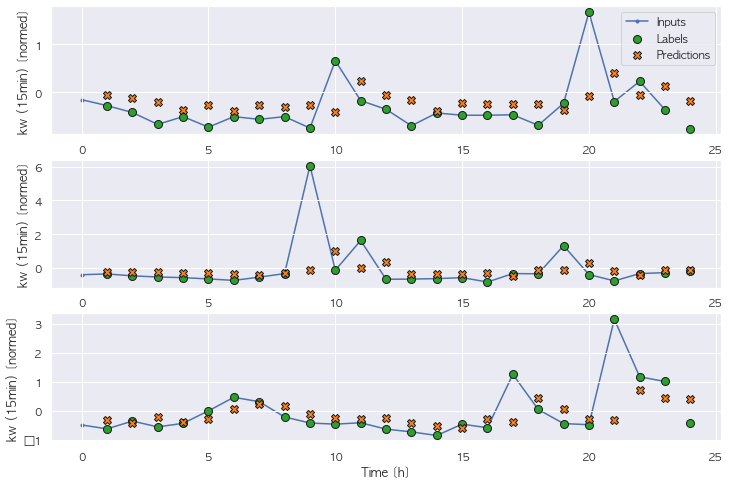

In [60]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test)

single_step_window.plot(dense)
wide_window.plot(dense)

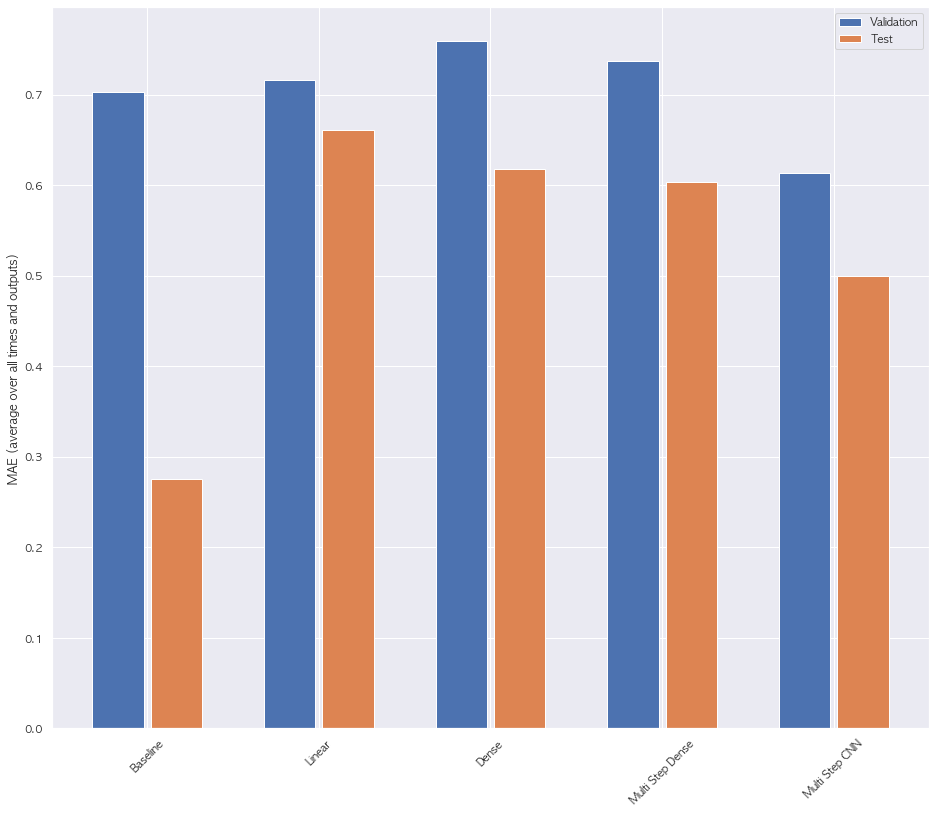

In [70]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
val_mae = [v[0] for v in val_performance.values()]
test_mae = [v[1] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

# Multi Step Model
---
### 단일 스텝은 현재 타임스텝들에 대한 컨텍스트는 존재하지 않는다. 오로지 그 값만을 참고하여 예측값을 출력한다.
- 이는 시간에 따라 입력 특성이 어떻게 볼 수 없다는 단점이 존재한다.

In [49]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['kw (15min)'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['kw (15min)']

## Multi Step Dense
---
### Flatten Layer를 모델에 넣어서 다중 타임스텝 처리가 가능하도록 구성한다.
- 하지만 일반 밀집층을 통해 Multi Step을 구성하면, 훈련때 사용했던 타임스텝의 양만큼을 입력값으로 사용해야 예측이 가능하다는 단점이 있다.
    - 다른 입력길에서는 동작하지 않는다.

Epoch 1/20
192/192 [==============================] - 1s 2ms/step - loss: 0.9457 - mean_absolute_error: 0.5890 - val_loss: 0.7207 - val_mean_absolute_error: 0.6665
Epoch 2/20
192/192 [==============================] - 0s 2ms/step - loss: 0.9148 - mean_absolute_error: 0.5748 - val_loss: 0.7475 - val_mean_absolute_error: 0.6988
Epoch 3/20
55/55 [==============================] - 0s 830us/step - loss: 0.7371 - mean_absolute_error: 0.6901


/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


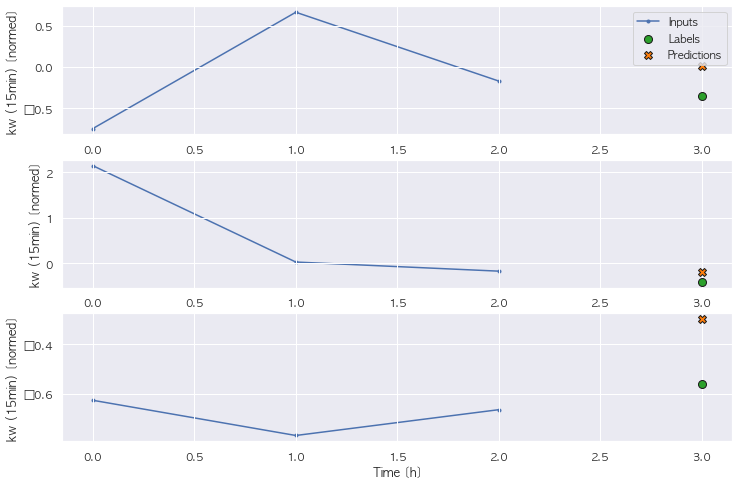

In [63]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

history = compile_and_fit(multi_step_dense, conv_window)

val_performance['Multi Step Dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi Step Dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

conv_window.plot(multi_step_dense)

## CNN (Convolution Neural Network)
---

In [68]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['kw (15min)'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['kw (15min)']

Epoch 1/20
192/192 [==============================] - 1s 2ms/step - loss: 0.9295 - mean_absolute_error: 0.5900 - val_loss: 0.6900 - val_mean_absolute_error: 0.6408
Epoch 2/20
192/192 [==============================] - 0s 2ms/step - loss: 0.9111 - mean_absolute_error: 0.5730 - val_loss: 0.6761 - val_mean_absolute_error: 0.6295
Epoch 3/20
192/192 [==============================] - 0s 2ms/step - loss: 0.9051 - mean_absolute_error: 0.5702 - val_loss: 0.6684 - val_mean_absolute_error: 0.6163
Epoch 4/20
192/192 [==============================] - 0s 2ms/step - loss: 0.9040 - mean_absolute_error: 0.5698 - val_loss: 0.6594 - val_mean_absolute_error: 0.6119
Epoch 5/20
192/192 [==============================] - 0s 1ms/step - loss: 0.9018 - mean_absolute_error: 0.5698 - val_loss: 0.6431 - val_mean_absolute_error: 0.5938
Epoch 6/20
192/192 [==============================] - 0s 1ms/step - loss: 0.8998 - mean_absolute_error: 0.5671 - val_loss: 0.6178 - val_mean_absolute_error: 0.5704
Epoch 7/20
192/1

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


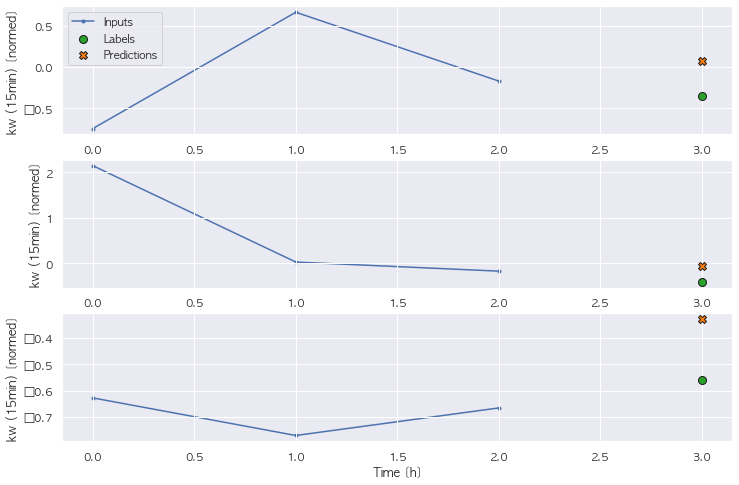

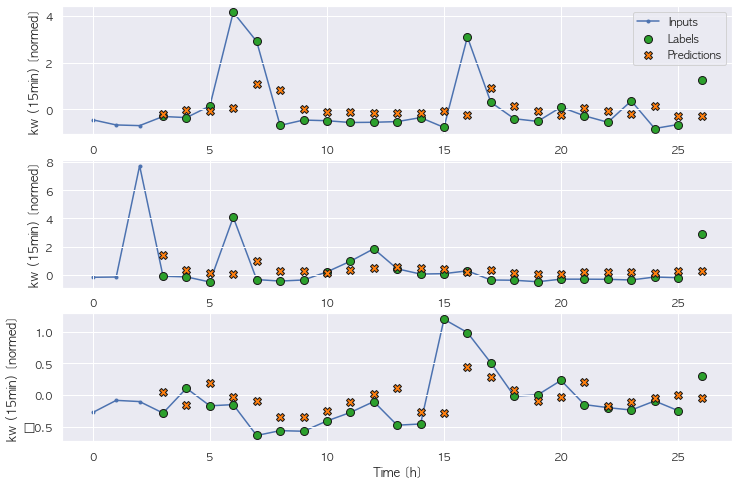

In [69]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

history = compile_and_fit(conv_model, conv_window)

val_performance['Multi Step CNN'] = conv_model.evaluate(conv_window.val)
performance['Multi Step CNN'] = conv_model.evaluate(conv_window.test, verbose=0)

conv_window.plot(conv_model)
wide_conv_window.plot(conv_model)